### Setting up plotting libraries and imports

In [27]:
import pandas as pd
import numpy as np


from itertools import  combinations_with_replacement


import matplotlib.pyplot as plt

plt.rcParams["pdf.fonttype"] = 42
plt.rcParams["font.sans-serif"] = "Helvetica"
plt.rcParams['axes.spines.right'] = False
plt.rcParams['axes.spines.top'] = False


from bokeh.io import output_notebook
output_notebook()

 import pathlib


extra_paths = ["../motifcount/", "../vis_util/"]
for p in extra_paths:
    if str(pathlib.Path(p).resolve()) not in sys.path:
        sys.path.append(str(pathlib.Path(p).resolve()))

Loading BokehJS ...

# Load Hemibrain data

In [28]:
oviINr_id = 423101189

# Correlation Coefficients of Inputs

Trying to compute the correlation coefficients of the input of each neuron

In [29]:
# the files in hemibrain/exported-traced-adjacencies-* come from executing the code below
# from neuprint import fetch_traced_adjacencies
# traced_df, roi_conn_df = fetch_traced_adjacencies('hemibrain/exported-traced-adjacencies-v1.2.1')


HB_edge_df = pd.read_csv("data/exported-traced-adjacencies-v1.2.1/total-connections.csv")  
HB_node_df = pd.read_csv("data/exported-traced-adjacencies-v1.2.1/neurons.csv", index_col=0).fillna("None")
# The file being loaded here sis present at this link: https://github.com/Gutierrez-lab/oviIN-analyses-gabrielle/blob/main/ovi_preprocessed/preprocessed_inputs-v1.2.1/preprocessed_nodes.csv
oviIN_nodes = pd.read_csv("../flybrain-clustering/oviIN/preprocessed_inputs-v1.2.1/preprocessed_nodes.csv", index_col=0)

# We filter the nodes to only consider traced and uncropped neurons
oviIN_nodes = oviIN_nodes[np.logical_and(oviIN_nodes['status'] == 'Traced', oviIN_nodes['cropped'] == False)]

# must replace oviIN_nodes with the correct data.
valid_ovi_nodes = np.intersect1d(oviIN_nodes.index, HB_node_df.index)

In [30]:
shuffled_df = oviIN_nodes.loc[valid_ovi_nodes, ["0.0", "0.05", "0.1", "0.5", "0.75", "1.0", "instance", "celltype"]]
chis = ["0.0"]
n_trials = 100

for chi in chis:
    shuffles = np.zeros((len(shuffled_df), n_trials), dtype=int)
    for t in range(n_trials):
        shuffles[:, t] = shuffled_df[chi].values[np.random.permutation(len(shuffled_df))]
    tmp = pd.DataFrame(shuffles, index=shuffled_df.index, columns=[f"{chi}_s{t}" for t in range(n_trials)])
    shuffled_df = shuffled_df.merge(tmp, left_index=True, right_index=True)
shuffled_df

,0.0,0.05,0.1,0.5,0.75,1.0,instance,celltype,0.0_s0,0.0_s1,...,0.0_s90,0.0_s91,0.0_s92,0.0_s93,0.0_s94,0.0_s95,0.0_s96,0.0_s97,0.0_s98,0.0_s99
id,,,,,,,,,,,,,,,,,,,,,
263674097,5,8,8,154,202,198,LHPD2a5_a_R,LHPD2a5_a,2,3,...,1,1,5,2,5,3,5,5,5,3
266187480,5,5,20,240,300,251,SMP349_R,SMP349,5,3,...,5,1,3,3,4,2,2,3,3,3
266187559,5,5,20,90,110,252,SLP399_R,SLP399,2,1,...,3,2,1,3,1,1,2,1,5,1
267214250,5,5,20,241,301,253,pC1b_R,pC1b,3,5,...,3,1,3,3,5,5,3,1,1,2
267223104,5,5,20,242,302,254,SMP025_R,SMP025,1,1,...,5,4,5,1,2,2,4,3,3,5
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5901225755,2,7,7,357,141,153,NaN,NaN,3,2,...,5,5,3,5,5,2,3,1,3,2
5901227238,2,7,7,130,229,145,NaN,NaN,2,2,...,1,1,4,2,3,3,1,3,5,1
5901232053,1,13,15,248,311,266,SMP272(PDL21)_L,SMP272,3,1,...,3,4,3,5,1,1,3,5,3,3


In [31]:
valid_ovi_nodes

array([ 263674097,  266187480,  266187559, ..., 5901232053, 6400000773,
       7112622044])

In [32]:
valid_ovi_nodes = np.array(sorted(valid_ovi_nodes, key=lambda x: oviIN_nodes.loc[x, "0.0"]))
valid_ovi_nodes

array([ 296199021,  296203325,  296203440, ..., 5901203505, 5901221890,
       6400000773])

In [33]:
test_ovi_nodes = valid_ovi_nodes[:5]
test_ovi_nodes

array([296199021, 296203325, 296203440, 296531366, 296535655])

In [34]:
# This cell takes ~ 15 seconds to work and takes up a lot of memory
HB_matrix = HB_edge_df.pivot_table(values="weight", index="bodyId_post", columns="bodyId_pre", fill_value=0.0)

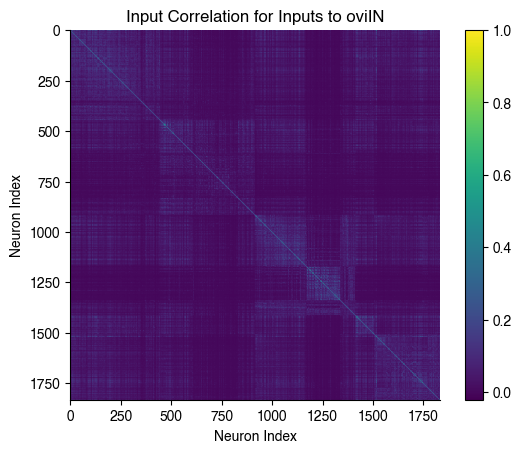

In [35]:
X = HB_matrix.loc[valid_ovi_nodes].values
C = np.corrcoef(X)
plt.imshow(C)
plt.title("Input Correlation for Inputs to oviIN")
plt.xlabel("Neuron Index")
plt.ylabel("Neuron Index")
plt.colorbar()
# plt.xticks(range(len(valid_ovi_nodes)), valid_ovi_nodes, rotation="vertical")
# plt.savefig(f"figures/input_correlation/all_input_correlation.pdf", bbox_inches="tight")

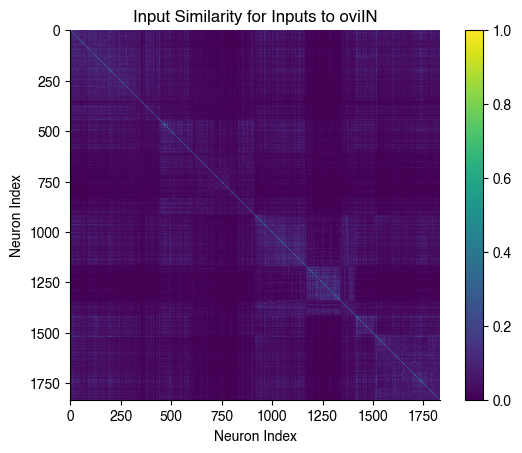

In [36]:
Xunit = X / np.sqrt(np.sum(X ** 2, axis=1))[:,None]
S = Xunit @ Xunit.T
plt.imshow(S)
plt.title("Input Similarity for Inputs to oviIN")
plt.xlabel("Neuron Index")
plt.ylabel("Neuron Index")
plt.colorbar()
# plt.savefig(f"figures/input_correlation/all_input_similarity.pdf", bbox_inches="tight")

In [37]:
corr_df = pd.DataFrame([[valid_ovi_nodes[i], valid_ovi_nodes[j], C[i,j], S[i,j]] for (i,j) in combinations_with_replacement(range(len(valid_ovi_nodes)), 2)],
                       columns=["bodyId1", "bodyId2", "correlation", "similarity"])

# corr_df = corr_df.merge(oviIN_nodes["0.0"], left_on="bodyId1", right_index=True)
# corr_df = corr_df.merge(oviIN_nodes["0.0"], left_on="bodyId2", right_index=True, suffixes=["_1","_2"])
corr_df = corr_df.merge(shuffled_df, left_on="bodyId1", right_index=True)
corr_df = corr_df.merge(shuffled_df, left_on="bodyId2", right_index=True, suffixes=["_1", "_2"])
corr_df

,bodyId1,bodyId2,correlation,similarity,0.0_1,0.05_1,0.1_1,0.5_1,0.75_1,1.0_1,...,0.0_s90_2,0.0_s91_2,0.0_s92_2,0.0_s93_2,0.0_s94_2,0.0_s95_2,0.0_s96_2,0.0_s97_2,0.0_s98_2,0.0_s99_2
0,296199021,296199021,1.000000,1.000000,1,5,6,244,304,256,...,3,3,2,5,5,5,1,2,1,2
1,296199021,296203325,0.368179,0.370403,1,5,6,244,304,256,...,2,3,2,5,3,2,5,1,2,2
2,296199021,296203440,0.124859,0.127660,1,5,6,244,304,256,...,3,3,2,3,3,5,1,2,5,2
3,296199021,296531366,0.249489,0.251376,1,5,6,244,304,256,...,3,3,5,1,5,1,2,3,3,4
4,296199021,296535655,0.061815,0.064565,1,5,6,244,304,256,...,4,5,2,1,3,1,5,1,5,2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1679023,5901203505,5901221890,0.081568,0.085378,5,5,20,271,425,392,...,1,1,1,3,3,2,1,3,1,2
1679024,5901203505,6400000773,0.016982,0.020159,5,5,20,271,425,392,...,5,2,2,1,1,1,2,2,2,1
1679025,5901221890,5901221890,1.000000,1.000000,5,5,20,240,318,273,...,1,1,1,3,3,2,1,3,1,2
1679026,5901221890,6400000773,0.043026,0.046729,5,5,20,240,318,273,...,5,2,2,1,1,1,2,2,2,1


In [38]:
valid_corrs = corr_df[corr_df.bodyId1 != corr_df.bodyId2]

In [39]:
def corrDF_to_matrix(df, col1, col2, measure, stat):
    group_corrs = df.groupby([col1, col2]).agg({measure: stat})
    ngroups = df[col1].max()
    C = np.zeros((ngroups, ngroups))
    for i in range(ngroups):
        for j in range(i, ngroups):
            C[i,j] = C[j,i] = group_corrs.loc[(i+1, j+1), measure]
    return C

In [40]:
# true_corrs = valid_corrs.groupby(["0.0_1", "0.0_2"]).agg({"correlation": ["median", "mean", "std"], "similarity": ["median", "mean", "std"]})
cluster_corrs = valid_corrs.groupby(["0.0_1", "0.0_2"]).agg({"correlation": ["median", "mean", "std"], "similarity": ["median", "mean", "std"]})
cluster_corrs

correlation                     similarity                    
                 median      mean       std     median      mean       std
0.0_1 0.0_2                                                               
1     1        0.033626  0.064780  0.087271   0.036892  0.067869  0.087016
      2        0.003185  0.018195  0.042458   0.006307  0.021262  0.042489
      3        0.002726  0.021010  0.050872   0.006383  0.024704  0.050652
      4        0.016768  0.043070  0.069552   0.019452  0.045542  0.069306
      5        0.012525  0.036012  0.061598   0.015880  0.039203  0.061386
2     2        0.009964  0.037216  0.073250   0.012923  0.040043  0.073227
      3        0.000494  0.016447  0.043936   0.003913  0.019943  0.043925
      4        0.003433  0.022721  0.048536   0.005889  0.025096  0.048621
      5        0.000110  0.013877  0.039437   0.003157  0.016960  0.039424
3     3        0.017849  0.054311  0.090538   0.021913  0.058348  0.090253
      4        0.004902  0.024422  0.053518   0.007768  0.027288  0.053339
      5        0.004417  0.022842  0.050119   0.008023  0.026521  0.049962
4     4        0.050269  0.094297  0.126466   0.052143  0.096104  0.126216
      5        0.012814  0.037315  0.066659   0.015557  0.039806  0.066356
5     5        0.035533  0.067516  0.092716   0.038884  0.070587  0.092403

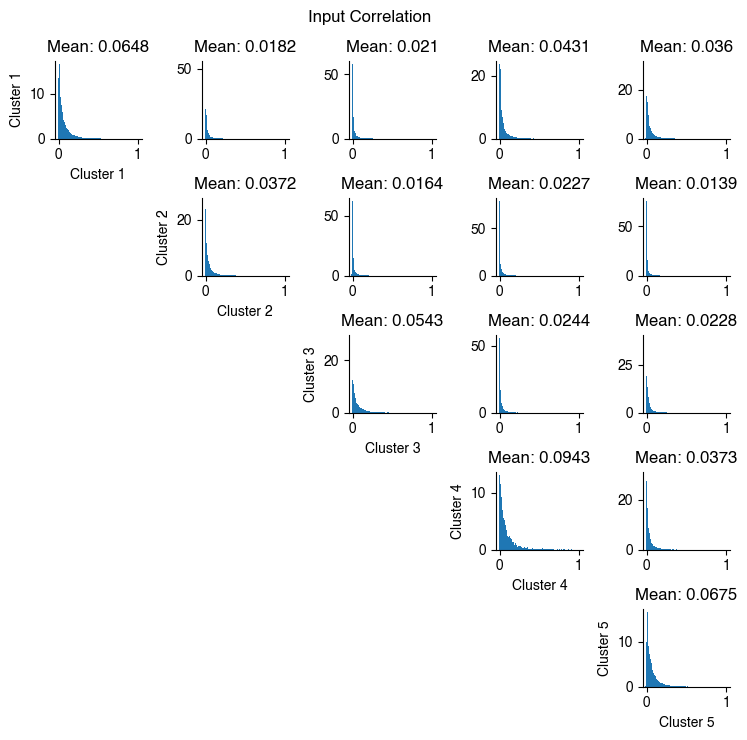

In [41]:
eps = 0.05
measure = "correlation"
stat = "mean"
plt.figure(tight_layout="tight",
           figsize=(7.5, 7.5))
plt.suptitle(f"Input {measure.capitalize()}")
for i in range(5):
    for j in range(i,5):
        plt.subplot(5,5,i*5 + j + 1)
        plt.hist(valid_corrs[(valid_corrs["0.0_1"] == (i+1)) & (valid_corrs["0.0_2"] == (j+1))][measure],
                 bins=100, density=True)
        # plt.axvline(cluster_corrs.loc[(i+1, j+1), (measure, stat)], color="red")
        plt.xlim(-eps, 1 + eps)
        plt.title(f"{stat.capitalize()}: {round(cluster_corrs.loc[(i+1, j+1), (measure, stat)], 4)}")
        if j == i:
            plt.xlabel(f"Cluster {i+1}")
            plt.ylabel(f"Cluster {j+1}")

# plt.savefig(f"figures/input_correlation/oviIN_input_connectome_input_{measure}.pdf", bbox_inches="tight")

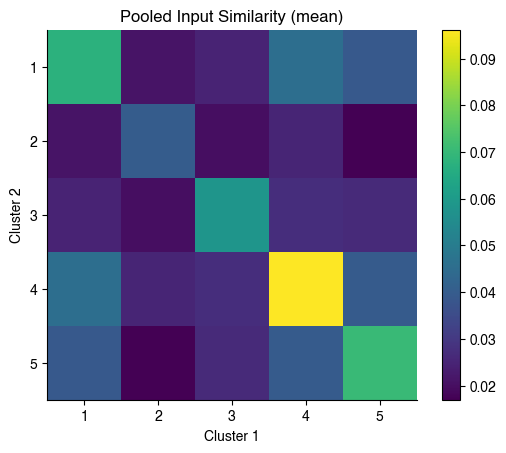

In [42]:
measure = "similarity"
stat = "mean"

CC = np.zeros((5,5))
CC = corrDF_to_matrix(valid_corrs, "0.0_1", "0.0_2", measure, stat)

plt.imshow(CC)
plt.title(f"Pooled Input {measure.capitalize()} ({stat})")
plt.xticks(range(5), range(1,6))
plt.yticks(range(5), range(1,6))
plt.xlabel("Cluster 1")
plt.ylabel("Cluster 2")
plt.colorbar()

In [43]:
n_trials = 100
lots_of_C = np.zeros((n_trials, 5, 5))
for t in range(n_trials):
    lots_of_C[t, :, :] = corrDF_to_matrix(valid_corrs, f"0.0_s{t}_1", f"0.0_s{t}_2", measure, stat)

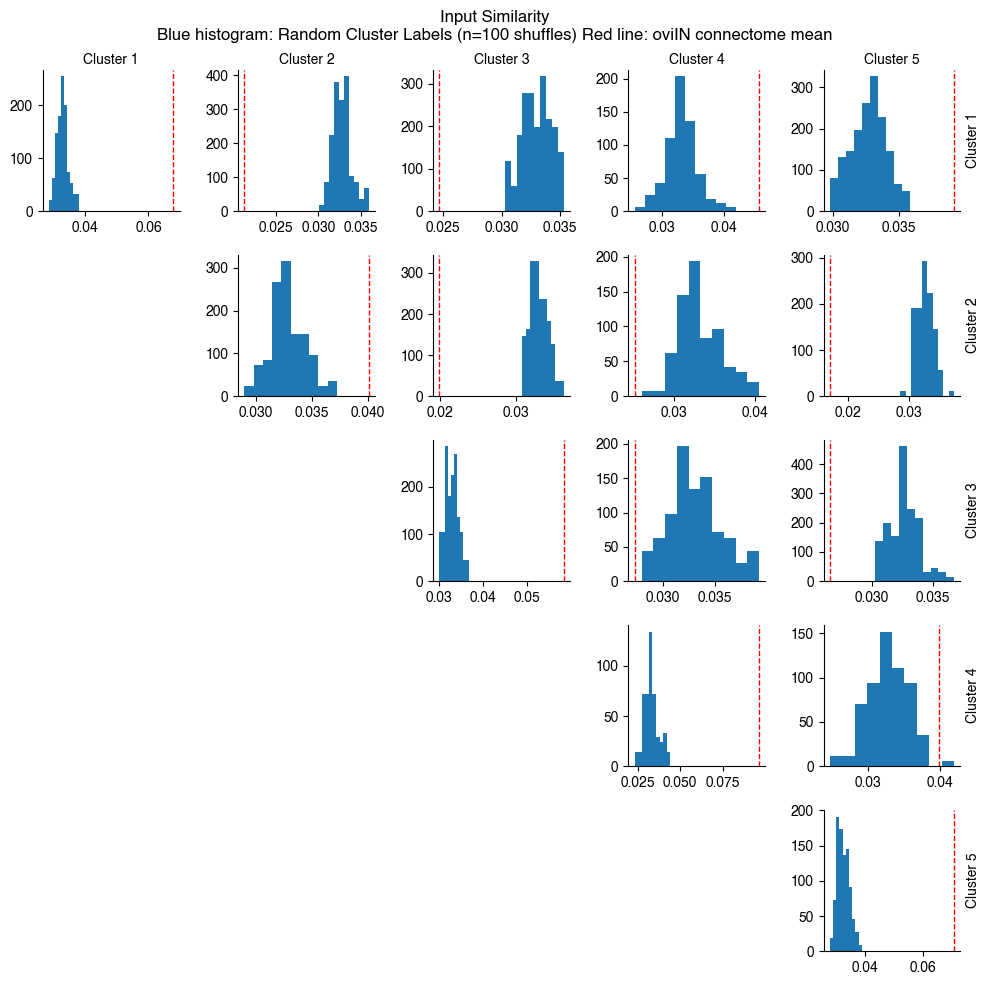

In [44]:
eps = 0.05
measure = "similarity"
stat = "mean"

lots_of_C = np.zeros((n_trials, 5, 5))
for t in range(n_trials):
    lots_of_C[t, :, :] = corrDF_to_matrix(valid_corrs, f"0.0_s{t}_1", f"0.0_s{t}_2", measure, stat)

plt.figure(tight_layout="tight",
           figsize=(10,10))
plt.suptitle(f"Input {measure.capitalize()}\nBlue histogram: Random Cluster Labels (n={n_trials} shuffles)\tRed line: oviIN connectome {stat}")
for i in range(5):
    for j in range(i,5):
        plt.subplot(5,5,i*5 + j + 1)
        plt.axvline(CC[i, j], color="red", linewidth=1, linestyle="dashed")
        plt.hist(lots_of_C[:, i, j], bins=10, density=True)
        if i == 0:
            plt.gca().xaxis.set_label_position("top")
            plt.xlabel(f"Cluster {j+1}")
            # plt.title(f"Cluster {j+1}")
        if j == 4:
            plt.gca().yaxis.set_label_position("right")
            plt.ylabel(f"Cluster {i+1}")

# plt.savefig(f"figures/input_correlation/comparison_to_shuffle_{measure}.pdf")